# Customer Churn Prediction with XGBoost Classifier

---



**Setting the random seed for reproducibility**

In [1]:
seed = 42

**Importing the necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

**Reading the CSV file**

In [3]:
churn = "/content/Customer Churn Data/Churn_Modelling.csv"
c_churn = pd.read_csv(churn)
c_churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Data Pre-processing

**We observe that the columns "RowNumber", "CustomerId" and "Surname" will have no impact on wether a customer will leave the bank; so we drop these columns.**

In [4]:
c_churn.drop(["RowNumber","CustomerId","Surname"], axis = 1, inplace = True)

In [5]:
c_churn.shape

(10000, 11)

In [6]:
c_churn

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


**Observe that "Gender" and "Geography" are textual categorical data, so we label encode them with Scikit Learn's method LabekEncoder.**

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
c_churn["Gender"] = label_encoder.fit_transform(c_churn["Gender"])
c_churn["Geography"] = label_encoder.fit_transform(c_churn["Geography"])
c_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


**Making the feature dataframe: X and Target dataframe: y**

In [8]:
X = c_churn.drop("Exited", axis = 1)
y = c_churn["Exited"]
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [9]:
c_churn["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

**Here, we see that there is a class imbalance; only 20% cases are 1 or, only 20% of customers have exited the bank.**
<br>
**Hence we do Over Sampling of the data so as to get an even ratio of both categories.**

In [10]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(sampling_strategy = 'minority', random_state = seed)
Xn,yn = os.fit_resample(X, y)
yn.value_counts()

Exited
1    7963
0    7963
Name: count, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xn, yn, test_size = 0.2, random_state = seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12740, 10), (12740,), (3186, 10), (3186,))

**Splitting the train set to get 20% Eval set**

In [12]:
n = int(len(X_train)*0.8)
X_train_fit, y_train_fit, X_train_eval, y_train_eval = X_train[:n], y_train[:n], X_train[n:], y_train[n:]

## Optimizing the hyperparameters for XGBoost Classifier

**Here we optimized only `n_estimators` and `learning_rate`**

In [13]:
n_estimators_list = [100, 300, 500, 700, 900, 1100, 1200, 1500]
learning_rate_list = [0.006, 0.01, 0.03, 0.1, 0.3, 0.6, 1.0]

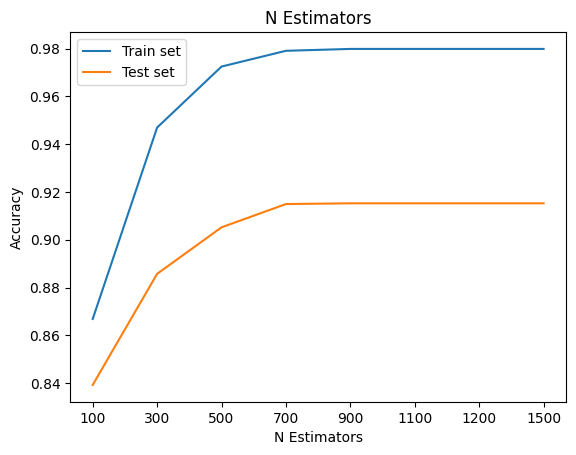

In [14]:
accu_train = []
accu_test = []

for n_estimators in n_estimators_list:
  model = XGBClassifier(n_estimators = n_estimators, learning_rate = 0.1, verbosity = 1, early_stopping_rounds = 10, random_state = seed)
  model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)], verbose = False)
  model.best_iteration

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  train_accuracy = accuracy_score(y_train_pred, y_train)
  test_accuracy = accuracy_score(y_test_pred, y_test)
  accu_train.append(train_accuracy)
  accu_test.append(test_accuracy)

plt.title("N Estimators")
plt.ylabel("Accuracy")
plt.xlabel("N Estimators")
plt.xticks(ticks = range(len(n_estimators_list)), labels = n_estimators_list)
plt.plot(accu_train)
plt.plot(accu_test)
plt.legend(["Train set","Test set"])
plt.show()

**We set `n_estimators = 700`**

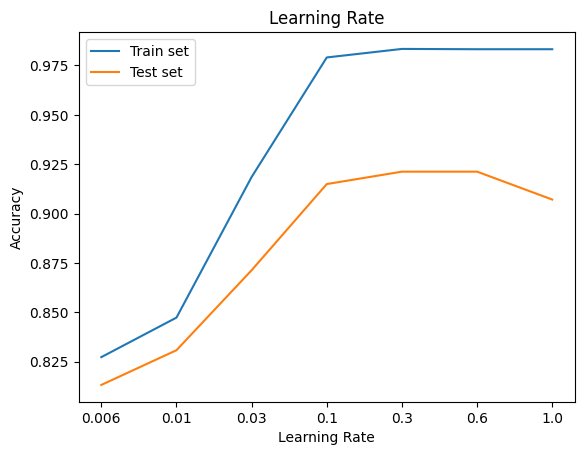

In [15]:
accu_train = []
accu_test = []

for learning_rate in learning_rate_list:
  model = XGBClassifier(n_estimators = 700, learning_rate = learning_rate, verbosity = 1, early_stopping_rounds = 10, random_state = seed)
  model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)], verbose = False)
  model.best_iteration

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  train_accuracy = accuracy_score(y_train_pred, y_train)
  test_accuracy = accuracy_score(y_test_pred, y_test)
  accu_train.append(train_accuracy)
  accu_test.append(test_accuracy)

plt.title("Learning Rate")
plt.ylabel("Accuracy")
plt.xlabel("Learning Rate")
plt.xticks(ticks = range(len(learning_rate_list)), labels = learning_rate_list)
plt.plot(accu_train)
plt.plot(accu_test)
plt.legend(["Train set","Test set"])
plt.show()

**We set `learning_rate = 0.6`**

##Implementing the model and checking the accuracy

In [16]:
model = XGBClassifier(n_estimators = 700, learning_rate = 0.6, verbosity = 1, random_state = seed, early_stopping_rounds = 10)
model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)], verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [17]:
model.best_iteration

157

**Best accuracy is achieved at iteration 157**

In [18]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [19]:
print(f"Train Accuracy: {accuracy_score(y_train_pred, y_train)}\nTest Accuracy: {accuracy_score(y_test_pred, y_test)}")

Train Accuracy: 0.9832025117739404
Test Accuracy: 0.921217827997489


**Final accuracy of test set is approximately 0.921**